# Federated Learning + Linear Quantization for RESNET18 & CIFAR10

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import numpy as np
from tqdm import tqdm
import seaborn as sns
from fedlern.utils import *
from fedlern.train_utils import *
from fedlern.quant_utils import *
from fedlern.models.resnet_v2 import ResNet18

## Relevant Parameters

In [77]:
epoch = 5
rounds = 30#40#25
num_clients = 10
lrn_rate = 0.1
clients_sample_size = int(.3 * num_clients) # Use 30% of available clients
num_workers = 8
train_batch_size = 32 #128
eval_batch_size= 32 #256
quantize_bits = 8
stats = (0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)

## Data Loaders
- Divide the test & training data
- Divide the training data among the clients

In [78]:
 # Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# Normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)

# split the training data
train_splits = torch.utils.data.random_split(train_dataset, [int(train_dataset.data.shape[0]/num_clients) for i in range(num_clients)])

# Data loaders
train_loaders = [DataLoader(dataset=split, batch_size=train_batch_size, shuffle=True, num_workers=num_workers) for split in train_splits]
test_loader = DataLoader(dataset=test_dataset, batch_size=eval_batch_size, shuffle=False, num_workers=num_workers)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Files already downloaded and verified



- `server_aggregate` function aggregates the model weights received from every client and updates the global model with the updated weights.

## Global & Clients instatiation
Implement the same elements as before, but:
- We need more instances of the model
- An optimizer for each model

In [79]:
global_model = ResNet18().to(device)
client_models = [ResNet18()
                     .to(device)
                     #.load_state_dict(global_model.state_dict())
                  for _ in range(num_clients)]


# Define the criterion, and pair of optimizers for global model
The first optimizer holds the regular weights, while the second one holds the quantized parameters, which are to be propagated to the clients.

In [80]:
# Optimizer & criterion based on gobal model
global_optimizer = get_model_optimizer(global_model,
                                       learning_rate=lrn_rate,
                                       weight_decay=5e-4)
criterion = nn.CrossEntropyLoss().to(device) # computes the cross-entropy loss between the predicted and true labels

# ----Optimizer for quantized model on global model----
# Copy the parameters
all_G_kernels = [kernel.data.clone().requires_grad_(True)
                for kernel in global_optimizer.param_groups[1]['params']]

kernels = [{'params': all_G_kernels}]

# New optimizer for the quantized weights
goptimizer_quant = optim.SGD(kernels, lr=0)





## Define optimizers for the clients.
Each clients has a pair of optimizers

In [81]:

optimizers = [get_model_optimizer(model,learning_rate=lrn_rate, weight_decay=5e-4) for model in client_models]


optimizers_quant = []
for optimizer in optimizers:
    # Copy the parameters
    all_G_kernels = [kernel.data.clone().requires_grad_(True)
                    for kernel in optimizer.param_groups[1]['params']]

    # Handle of the optimizer parameters
    all_W_kernels = optimizer.param_groups[1]['params']
    kernels = [{'params': all_G_kernels}]

    # New optimizer for the quantized weights
    optimizer_quant = optim.SGD(kernels, lr=0)
    optimizers_quant.append(optimizer_quant)


In [82]:
server_test = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(evaluate_model)

In [83]:
# initialize lists to store the training and testing losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for round in tqdm(range(rounds)):


    # Select n random clients
    selected_clients = np.random.permutation(num_clients)[:clients_sample_size]
    # Train the selected clients
    for client in selected_clients:
        # Individual criterion and optimizer
        print(f"Client {client} training")
        train_loss, train_acc = qtrain_model(model = client_models[client],
                                             train_loader = train_loaders[client],
                                             device = device,
                                             criterion = criterion,
                                             optimizer = optimizers[client],
                                             optimizer_quant = optimizers_quant[client],
                                             num_epochs=epoch,
                                             bits = quantize_bits)

    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Aggregate in 2 steps
    server_aggregate(global_model, client_models)
    server_quantize(global_optimizer, goptimizer_quant, quantize_bits)

    # Test the global model
    test_loss, test_acc = server_test(model=global_model,
                                      test_loader=test_loader,
                                      device=device,
                                      criterion=criterion)

    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    print(f"{round}-th ROUND: average train loss {(train_loss / clients_sample_size):0.3g} | test loss {test_loss:0.3g} | test acc: {test_acc:0.3f}")
    
    

  0%|          | 0/30 [00:00<?, ?it/s]

Client 5 training
Epoch: 0/5 Train Loss: 2.829 Train Acc: 0.161
Epoch: 1/5 Train Loss: 2.107 Train Acc: 0.186
Epoch: 2/5 Train Loss: 2.018 Train Acc: 0.207
Epoch: 3/5 Train Loss: 1.975 Train Acc: 0.226
Epoch: 4/5 Train Loss: 1.912 Train Acc: 0.262
Client 9 training
Epoch: 0/5 Train Loss: 2.545 Train Acc: 0.165
Epoch: 1/5 Train Loss: 2.084 Train Acc: 0.226
Epoch: 2/5 Train Loss: 1.988 Train Acc: 0.254
Epoch: 3/5 Train Loss: 1.911 Train Acc: 0.288
Epoch: 4/5 Train Loss: 1.839 Train Acc: 0.310
Client 2 training
Epoch: 0/5 Train Loss: 2.794 Train Acc: 0.155
Epoch: 1/5 Train Loss: 2.030 Train Acc: 0.226
Epoch: 2/5 Train Loss: 1.903 Train Acc: 0.280
Epoch: 3/5 Train Loss: 1.827 Train Acc: 0.306
Epoch: 4/5 Train Loss: 1.744 Train Acc: 0.348


  3%|▎         | 1/30 [02:52<1:23:26, 172.63s/it]

0-th ROUND: average train loss 0.581 | test loss 2.33 | test acc: 0.100
Client 8 training
Epoch: 0/5 Train Loss: 2.174 Train Acc: 0.186
Epoch: 1/5 Train Loss: 2.003 Train Acc: 0.242
Epoch: 2/5 Train Loss: 1.931 Train Acc: 0.274
Epoch: 3/5 Train Loss: 1.868 Train Acc: 0.296
Epoch: 4/5 Train Loss: 1.810 Train Acc: 0.325
Client 9 training
Epoch: 0/5 Train Loss: 2.139 Train Acc: 0.188
Epoch: 1/5 Train Loss: 1.971 Train Acc: 0.247
Epoch: 2/5 Train Loss: 1.883 Train Acc: 0.287
Epoch: 3/5 Train Loss: 1.836 Train Acc: 0.310
Epoch: 4/5 Train Loss: 1.763 Train Acc: 0.336
Client 1 training
Epoch: 0/5 Train Loss: 2.143 Train Acc: 0.193
Epoch: 1/5 Train Loss: 1.950 Train Acc: 0.264
Epoch: 2/5 Train Loss: 1.877 Train Acc: 0.303
Epoch: 3/5 Train Loss: 1.799 Train Acc: 0.326
Epoch: 4/5 Train Loss: 1.761 Train Acc: 0.348


  7%|▋         | 2/30 [05:44<1:20:24, 172.31s/it]

1-th ROUND: average train loss 0.587 | test loss 2.34 | test acc: 0.100
Client 2 training
Epoch: 0/5 Train Loss: 2.024 Train Acc: 0.230
Epoch: 1/5 Train Loss: 1.894 Train Acc: 0.279
Epoch: 2/5 Train Loss: 1.817 Train Acc: 0.309
Epoch: 3/5 Train Loss: 1.763 Train Acc: 0.346
Epoch: 4/5 Train Loss: 1.746 Train Acc: 0.345
Client 7 training
Epoch: 0/5 Train Loss: 2.022 Train Acc: 0.216
Epoch: 1/5 Train Loss: 1.878 Train Acc: 0.287
Epoch: 2/5 Train Loss: 1.844 Train Acc: 0.293
Epoch: 3/5 Train Loss: 1.747 Train Acc: 0.350
Epoch: 4/5 Train Loss: 1.700 Train Acc: 0.353
Client 3 training
Epoch: 0/5 Train Loss: 2.012 Train Acc: 0.247
Epoch: 1/5 Train Loss: 1.881 Train Acc: 0.293
Epoch: 2/5 Train Loss: 1.830 Train Acc: 0.307
Epoch: 3/5 Train Loss: 1.760 Train Acc: 0.335
Epoch: 4/5 Train Loss: 1.721 Train Acc: 0.349


 10%|█         | 3/30 [08:36<1:17:26, 172.08s/it]

2-th ROUND: average train loss 0.574 | test loss 2.37 | test acc: 0.100
Client 6 training
Epoch: 0/5 Train Loss: 1.902 Train Acc: 0.279
Epoch: 1/5 Train Loss: 1.785 Train Acc: 0.319
Epoch: 2/5 Train Loss: 1.691 Train Acc: 0.364
Epoch: 3/5 Train Loss: 1.633 Train Acc: 0.395
Epoch: 4/5 Train Loss: 1.588 Train Acc: 0.416
Client 4 training
Epoch: 0/5 Train Loss: 1.941 Train Acc: 0.264
Epoch: 1/5 Train Loss: 1.822 Train Acc: 0.313
Epoch: 2/5 Train Loss: 1.748 Train Acc: 0.344
Epoch: 3/5 Train Loss: 1.692 Train Acc: 0.372
Epoch: 4/5 Train Loss: 1.636 Train Acc: 0.405
Client 5 training
Epoch: 0/5 Train Loss: 1.916 Train Acc: 0.281
Epoch: 1/5 Train Loss: 1.779 Train Acc: 0.325
Epoch: 2/5 Train Loss: 1.729 Train Acc: 0.357
Epoch: 3/5 Train Loss: 1.698 Train Acc: 0.368
Epoch: 4/5 Train Loss: 1.626 Train Acc: 0.397


 13%|█▎        | 4/30 [11:28<1:14:34, 172.11s/it]

3-th ROUND: average train loss 0.542 | test loss 2.36 | test acc: 0.100
Client 1 training
Epoch: 0/5 Train Loss: 1.827 Train Acc: 0.321
Epoch: 1/5 Train Loss: 1.691 Train Acc: 0.380
Epoch: 2/5 Train Loss: 1.618 Train Acc: 0.404
Epoch: 3/5 Train Loss: 1.556 Train Acc: 0.427
Epoch: 4/5 Train Loss: 1.499 Train Acc: 0.463
Client 4 training
Epoch: 0/5 Train Loss: 1.825 Train Acc: 0.314
Epoch: 1/5 Train Loss: 1.693 Train Acc: 0.369
Epoch: 2/5 Train Loss: 1.619 Train Acc: 0.402
Epoch: 3/5 Train Loss: 1.567 Train Acc: 0.422
Epoch: 4/5 Train Loss: 1.493 Train Acc: 0.453
Client 2 training
Epoch: 0/5 Train Loss: 1.791 Train Acc: 0.327
Epoch: 1/5 Train Loss: 1.684 Train Acc: 0.366
Epoch: 2/5 Train Loss: 1.603 Train Acc: 0.406
Epoch: 3/5 Train Loss: 1.538 Train Acc: 0.437
Epoch: 4/5 Train Loss: 1.468 Train Acc: 0.466


 17%|█▋        | 5/30 [14:21<1:11:46, 172.26s/it]

4-th ROUND: average train loss 0.489 | test loss 2.31 | test acc: 0.134
Client 9 training
Epoch: 0/5 Train Loss: 1.672 Train Acc: 0.382
Epoch: 1/5 Train Loss: 1.564 Train Acc: 0.429
Epoch: 2/5 Train Loss: 1.473 Train Acc: 0.457
Epoch: 3/5 Train Loss: 1.420 Train Acc: 0.475
Epoch: 4/5 Train Loss: 1.363 Train Acc: 0.502
Client 4 training
Epoch: 0/5 Train Loss: 1.701 Train Acc: 0.367
Epoch: 1/5 Train Loss: 1.581 Train Acc: 0.425
Epoch: 2/5 Train Loss: 1.487 Train Acc: 0.451
Epoch: 3/5 Train Loss: 1.434 Train Acc: 0.476
Epoch: 4/5 Train Loss: 1.360 Train Acc: 0.505
Client 5 training
Epoch: 0/5 Train Loss: 1.669 Train Acc: 0.394
Epoch: 1/5 Train Loss: 1.594 Train Acc: 0.411
Epoch: 2/5 Train Loss: 1.487 Train Acc: 0.457
Epoch: 3/5 Train Loss: 1.431 Train Acc: 0.480
Epoch: 4/5 Train Loss: 1.365 Train Acc: 0.500


 20%|██        | 6/30 [17:13<1:08:55, 172.31s/it]

5-th ROUND: average train loss 0.455 | test loss 2.2 | test acc: 0.158
Client 3 training
Epoch: 0/5 Train Loss: 1.526 Train Acc: 0.437
Epoch: 1/5 Train Loss: 1.465 Train Acc: 0.469
Epoch: 2/5 Train Loss: 1.361 Train Acc: 0.514
Epoch: 3/5 Train Loss: 1.309 Train Acc: 0.529
Epoch: 4/5 Train Loss: 1.230 Train Acc: 0.561
Client 5 training
Epoch: 0/5 Train Loss: 1.547 Train Acc: 0.438
Epoch: 1/5 Train Loss: 1.442 Train Acc: 0.473
Epoch: 2/5 Train Loss: 1.366 Train Acc: 0.507
Epoch: 3/5 Train Loss: 1.291 Train Acc: 0.537
Epoch: 4/5 Train Loss: 1.239 Train Acc: 0.558
Client 4 training
Epoch: 0/5 Train Loss: 1.580 Train Acc: 0.423
Epoch: 1/5 Train Loss: 1.461 Train Acc: 0.477
Epoch: 2/5 Train Loss: 1.373 Train Acc: 0.500
Epoch: 3/5 Train Loss: 1.308 Train Acc: 0.536
Epoch: 4/5 Train Loss: 1.252 Train Acc: 0.558


 23%|██▎       | 7/30 [20:05<1:06:01, 172.26s/it]

6-th ROUND: average train loss 0.417 | test loss 2.12 | test acc: 0.227
Client 8 training
Epoch: 0/5 Train Loss: 1.443 Train Acc: 0.480
Epoch: 1/5 Train Loss: 1.352 Train Acc: 0.511
Epoch: 2/5 Train Loss: 1.278 Train Acc: 0.543
Epoch: 3/5 Train Loss: 1.220 Train Acc: 0.557
Epoch: 4/5 Train Loss: 1.170 Train Acc: 0.586
Client 3 training
Epoch: 0/5 Train Loss: 1.435 Train Acc: 0.474
Epoch: 1/5 Train Loss: 1.340 Train Acc: 0.524
Epoch: 2/5 Train Loss: 1.273 Train Acc: 0.543
Epoch: 3/5 Train Loss: 1.216 Train Acc: 0.562
Epoch: 4/5 Train Loss: 1.158 Train Acc: 0.588
Client 9 training
Epoch: 0/5 Train Loss: 1.433 Train Acc: 0.490
Epoch: 1/5 Train Loss: 1.345 Train Acc: 0.516
Epoch: 2/5 Train Loss: 1.263 Train Acc: 0.552
Epoch: 3/5 Train Loss: 1.206 Train Acc: 0.576
Epoch: 4/5 Train Loss: 1.160 Train Acc: 0.589


 27%|██▋       | 8/30 [22:58<1:03:09, 172.26s/it]

7-th ROUND: average train loss 0.387 | test loss 2.09 | test acc: 0.271
Client 5 training
Epoch: 0/5 Train Loss: 1.334 Train Acc: 0.513
Epoch: 1/5 Train Loss: 1.266 Train Acc: 0.552
Epoch: 2/5 Train Loss: 1.200 Train Acc: 0.574
Epoch: 3/5 Train Loss: 1.138 Train Acc: 0.589
Epoch: 4/5 Train Loss: 1.096 Train Acc: 0.610
Client 1 training
Epoch: 0/5 Train Loss: 1.303 Train Acc: 0.531
Epoch: 1/5 Train Loss: 1.243 Train Acc: 0.554
Epoch: 2/5 Train Loss: 1.190 Train Acc: 0.572
Epoch: 3/5 Train Loss: 1.143 Train Acc: 0.587
Epoch: 4/5 Train Loss: 1.092 Train Acc: 0.611
Client 7 training
Epoch: 0/5 Train Loss: 1.318 Train Acc: 0.526
Epoch: 1/5 Train Loss: 1.237 Train Acc: 0.560
Epoch: 2/5 Train Loss: 1.180 Train Acc: 0.576
Epoch: 3/5 Train Loss: 1.141 Train Acc: 0.587
Epoch: 4/5 Train Loss: 1.096 Train Acc: 0.612


 30%|███       | 9/30 [25:50<1:00:17, 172.26s/it]

8-th ROUND: average train loss 0.365 | test loss 2 | test acc: 0.301
Client 7 training
Epoch: 0/5 Train Loss: 1.233 Train Acc: 0.556
Epoch: 1/5 Train Loss: 1.173 Train Acc: 0.587
Epoch: 2/5 Train Loss: 1.133 Train Acc: 0.590
Epoch: 3/5 Train Loss: 1.089 Train Acc: 0.620
Epoch: 4/5 Train Loss: 1.060 Train Acc: 0.625
Client 1 training
Epoch: 0/5 Train Loss: 1.238 Train Acc: 0.552
Epoch: 1/5 Train Loss: 1.202 Train Acc: 0.568
Epoch: 2/5 Train Loss: 1.121 Train Acc: 0.600
Epoch: 3/5 Train Loss: 1.096 Train Acc: 0.612
Epoch: 4/5 Train Loss: 1.061 Train Acc: 0.633
Client 3 training
Epoch: 0/5 Train Loss: 1.245 Train Acc: 0.552
Epoch: 1/5 Train Loss: 1.197 Train Acc: 0.573
Epoch: 2/5 Train Loss: 1.137 Train Acc: 0.599
Epoch: 3/5 Train Loss: 1.081 Train Acc: 0.608
Epoch: 4/5 Train Loss: 1.062 Train Acc: 0.625


 33%|███▎      | 10/30 [28:42<57:26, 172.34s/it] 

9-th ROUND: average train loss 0.354 | test loss 1.92 | test acc: 0.347
Client 2 training
Epoch: 0/5 Train Loss: 1.164 Train Acc: 0.582
Epoch: 1/5 Train Loss: 1.116 Train Acc: 0.599
Epoch: 2/5 Train Loss: 1.069 Train Acc: 0.616
Epoch: 3/5 Train Loss: 1.023 Train Acc: 0.640
Epoch: 4/5 Train Loss: 0.981 Train Acc: 0.652
Client 7 training
Epoch: 0/5 Train Loss: 1.151 Train Acc: 0.594
Epoch: 1/5 Train Loss: 1.112 Train Acc: 0.596
Epoch: 2/5 Train Loss: 1.064 Train Acc: 0.629
Epoch: 3/5 Train Loss: 1.030 Train Acc: 0.636
Epoch: 4/5 Train Loss: 0.994 Train Acc: 0.648
Client 4 training
Epoch: 0/5 Train Loss: 1.186 Train Acc: 0.581
Epoch: 1/5 Train Loss: 1.141 Train Acc: 0.601
Epoch: 2/5 Train Loss: 1.096 Train Acc: 0.614
Epoch: 3/5 Train Loss: 1.061 Train Acc: 0.635
Epoch: 4/5 Train Loss: 0.993 Train Acc: 0.648


 37%|███▋      | 11/30 [31:35<54:36, 172.45s/it]

10-th ROUND: average train loss 0.331 | test loss 1.8 | test acc: 0.404
Client 5 training
Epoch: 0/5 Train Loss: 1.124 Train Acc: 0.596
Epoch: 1/5 Train Loss: 1.075 Train Acc: 0.616
Epoch: 2/5 Train Loss: 1.032 Train Acc: 0.632
Epoch: 3/5 Train Loss: 0.988 Train Acc: 0.647
Epoch: 4/5 Train Loss: 0.960 Train Acc: 0.662
Client 6 training
Epoch: 0/5 Train Loss: 1.062 Train Acc: 0.630
Epoch: 1/5 Train Loss: 1.022 Train Acc: 0.640
Epoch: 2/5 Train Loss: 0.986 Train Acc: 0.653
Epoch: 3/5 Train Loss: 0.961 Train Acc: 0.662
Epoch: 4/5 Train Loss: 0.934 Train Acc: 0.675
Client 7 training
Epoch: 0/5 Train Loss: 1.110 Train Acc: 0.613
Epoch: 1/5 Train Loss: 1.072 Train Acc: 0.624
Epoch: 2/5 Train Loss: 1.008 Train Acc: 0.648
Epoch: 3/5 Train Loss: 0.974 Train Acc: 0.659
Epoch: 4/5 Train Loss: 0.954 Train Acc: 0.666


 40%|████      | 12/30 [34:27<51:41, 172.31s/it]

11-th ROUND: average train loss 0.318 | test loss 1.59 | test acc: 0.480
Client 1 training
Epoch: 0/5 Train Loss: 1.024 Train Acc: 0.640
Epoch: 1/5 Train Loss: 1.035 Train Acc: 0.636
Epoch: 2/5 Train Loss: 1.008 Train Acc: 0.650
Epoch: 3/5 Train Loss: 0.961 Train Acc: 0.665
Epoch: 4/5 Train Loss: 0.919 Train Acc: 0.672
Client 8 training
Epoch: 0/5 Train Loss: 1.071 Train Acc: 0.621
Epoch: 1/5 Train Loss: 1.051 Train Acc: 0.629
Epoch: 2/5 Train Loss: 1.020 Train Acc: 0.650
Epoch: 3/5 Train Loss: 0.970 Train Acc: 0.661
Epoch: 4/5 Train Loss: 0.923 Train Acc: 0.676
Client 0 training
Epoch: 0/5 Train Loss: 1.051 Train Acc: 0.630
Epoch: 1/5 Train Loss: 1.025 Train Acc: 0.631
Epoch: 2/5 Train Loss: 0.982 Train Acc: 0.653
Epoch: 3/5 Train Loss: 0.949 Train Acc: 0.671
Epoch: 4/5 Train Loss: 0.926 Train Acc: 0.671


 43%|████▎     | 13/30 [37:19<48:48, 172.26s/it]

12-th ROUND: average train loss 0.309 | test loss 1.41 | test acc: 0.540
Client 2 training
Epoch: 0/5 Train Loss: 1.003 Train Acc: 0.648
Epoch: 1/5 Train Loss: 0.979 Train Acc: 0.657
Epoch: 2/5 Train Loss: 0.928 Train Acc: 0.673
Epoch: 3/5 Train Loss: 0.883 Train Acc: 0.690
Epoch: 4/5 Train Loss: 0.869 Train Acc: 0.694
Client 4 training
Epoch: 0/5 Train Loss: 0.994 Train Acc: 0.650
Epoch: 1/5 Train Loss: 0.997 Train Acc: 0.648
Epoch: 2/5 Train Loss: 0.916 Train Acc: 0.679
Epoch: 3/5 Train Loss: 0.921 Train Acc: 0.679
Epoch: 4/5 Train Loss: 0.871 Train Acc: 0.693
Client 8 training
Epoch: 0/5 Train Loss: 1.036 Train Acc: 0.630
Epoch: 1/5 Train Loss: 1.030 Train Acc: 0.645
Epoch: 2/5 Train Loss: 0.966 Train Acc: 0.665
Epoch: 3/5 Train Loss: 0.935 Train Acc: 0.674
Epoch: 4/5 Train Loss: 0.908 Train Acc: 0.683


 47%|████▋     | 14/30 [40:12<45:58, 172.39s/it]

13-th ROUND: average train loss 0.303 | test loss 1.27 | test acc: 0.582
Client 0 training
Epoch: 0/5 Train Loss: 0.974 Train Acc: 0.662
Epoch: 1/5 Train Loss: 0.922 Train Acc: 0.680
Epoch: 2/5 Train Loss: 0.928 Train Acc: 0.680
Epoch: 3/5 Train Loss: 0.885 Train Acc: 0.695
Epoch: 4/5 Train Loss: 0.855 Train Acc: 0.695
Client 9 training
Epoch: 0/5 Train Loss: 0.959 Train Acc: 0.661
Epoch: 1/5 Train Loss: 0.943 Train Acc: 0.664
Epoch: 2/5 Train Loss: 0.904 Train Acc: 0.680
Epoch: 3/5 Train Loss: 0.876 Train Acc: 0.692
Epoch: 4/5 Train Loss: 0.844 Train Acc: 0.703
Client 6 training
Epoch: 0/5 Train Loss: 0.929 Train Acc: 0.672
Epoch: 1/5 Train Loss: 0.914 Train Acc: 0.683
Epoch: 2/5 Train Loss: 0.892 Train Acc: 0.695
Epoch: 3/5 Train Loss: 0.840 Train Acc: 0.704
Epoch: 4/5 Train Loss: 0.823 Train Acc: 0.714


 50%|█████     | 15/30 [43:04<43:05, 172.34s/it]

14-th ROUND: average train loss 0.274 | test loss 1.1 | test acc: 0.636
Client 2 training
Epoch: 0/5 Train Loss: 0.914 Train Acc: 0.675
Epoch: 1/5 Train Loss: 0.883 Train Acc: 0.687
Epoch: 2/5 Train Loss: 0.872 Train Acc: 0.694
Epoch: 3/5 Train Loss: 0.848 Train Acc: 0.703
Epoch: 4/5 Train Loss: 0.834 Train Acc: 0.706
Client 9 training
Epoch: 0/5 Train Loss: 0.908 Train Acc: 0.690
Epoch: 1/5 Train Loss: 0.891 Train Acc: 0.691
Epoch: 2/5 Train Loss: 0.868 Train Acc: 0.696
Epoch: 3/5 Train Loss: 0.846 Train Acc: 0.709
Epoch: 4/5 Train Loss: 0.821 Train Acc: 0.718
Client 8 training
Epoch: 0/5 Train Loss: 0.947 Train Acc: 0.677
Epoch: 1/5 Train Loss: 0.921 Train Acc: 0.677
Epoch: 2/5 Train Loss: 0.903 Train Acc: 0.692
Epoch: 3/5 Train Loss: 0.877 Train Acc: 0.690
Epoch: 4/5 Train Loss: 0.856 Train Acc: 0.699


 53%|█████▎    | 16/30 [45:56<40:11, 172.28s/it]

15-th ROUND: average train loss 0.285 | test loss 1.01 | test acc: 0.656
Client 0 training
Epoch: 0/5 Train Loss: 0.867 Train Acc: 0.695
Epoch: 1/5 Train Loss: 0.894 Train Acc: 0.687
Epoch: 2/5 Train Loss: 0.881 Train Acc: 0.697
Epoch: 3/5 Train Loss: 0.819 Train Acc: 0.720
Epoch: 4/5 Train Loss: 0.801 Train Acc: 0.722
Client 6 training
Epoch: 0/5 Train Loss: 0.842 Train Acc: 0.709
Epoch: 1/5 Train Loss: 0.863 Train Acc: 0.704
Epoch: 2/5 Train Loss: 0.842 Train Acc: 0.710
Epoch: 3/5 Train Loss: 0.802 Train Acc: 0.725
Epoch: 4/5 Train Loss: 0.787 Train Acc: 0.723
Client 3 training
Epoch: 0/5 Train Loss: 0.919 Train Acc: 0.677
Epoch: 1/5 Train Loss: 0.917 Train Acc: 0.677
Epoch: 2/5 Train Loss: 0.870 Train Acc: 0.700
Epoch: 3/5 Train Loss: 0.853 Train Acc: 0.707
Epoch: 4/5 Train Loss: 0.825 Train Acc: 0.710


 57%|█████▋    | 17/30 [48:49<37:20, 172.34s/it]

16-th ROUND: average train loss 0.275 | test loss 0.872 | test acc: 0.703
Client 1 training
Epoch: 0/5 Train Loss: 0.885 Train Acc: 0.699
Epoch: 1/5 Train Loss: 0.885 Train Acc: 0.694
Epoch: 2/5 Train Loss: 0.829 Train Acc: 0.714
Epoch: 3/5 Train Loss: 0.840 Train Acc: 0.708
Epoch: 4/5 Train Loss: 0.781 Train Acc: 0.728
Client 5 training
Epoch: 0/5 Train Loss: 0.867 Train Acc: 0.697
Epoch: 1/5 Train Loss: 0.873 Train Acc: 0.696
Epoch: 2/5 Train Loss: 0.859 Train Acc: 0.703
Epoch: 3/5 Train Loss: 0.805 Train Acc: 0.720
Epoch: 4/5 Train Loss: 0.807 Train Acc: 0.724
Client 4 training
Epoch: 0/5 Train Loss: 0.866 Train Acc: 0.703
Epoch: 1/5 Train Loss: 0.868 Train Acc: 0.698
Epoch: 2/5 Train Loss: 0.832 Train Acc: 0.716
Epoch: 3/5 Train Loss: 0.816 Train Acc: 0.718
Epoch: 4/5 Train Loss: 0.813 Train Acc: 0.727


 60%|██████    | 18/30 [51:41<34:27, 172.27s/it]

17-th ROUND: average train loss 0.271 | test loss 0.787 | test acc: 0.734
Client 0 training
Epoch: 0/5 Train Loss: 0.846 Train Acc: 0.704
Epoch: 1/5 Train Loss: 0.841 Train Acc: 0.706
Epoch: 2/5 Train Loss: 0.803 Train Acc: 0.718
Epoch: 3/5 Train Loss: 0.822 Train Acc: 0.716
Epoch: 4/5 Train Loss: 0.785 Train Acc: 0.727
Client 4 training
Epoch: 0/5 Train Loss: 0.853 Train Acc: 0.703
Epoch: 1/5 Train Loss: 0.872 Train Acc: 0.695
Epoch: 2/5 Train Loss: 0.822 Train Acc: 0.713
Epoch: 3/5 Train Loss: 0.806 Train Acc: 0.721
Epoch: 4/5 Train Loss: 0.783 Train Acc: 0.728
Client 9 training
Epoch: 0/5 Train Loss: 0.847 Train Acc: 0.707
Epoch: 1/5 Train Loss: 0.825 Train Acc: 0.715
Epoch: 2/5 Train Loss: 0.804 Train Acc: 0.723
Epoch: 3/5 Train Loss: 0.803 Train Acc: 0.719
Epoch: 4/5 Train Loss: 0.769 Train Acc: 0.728


 63%|██████▎   | 19/30 [54:33<31:36, 172.38s/it]

18-th ROUND: average train loss 0.256 | test loss 0.742 | test acc: 0.742
Client 2 training
Epoch: 0/5 Train Loss: 0.794 Train Acc: 0.726
Epoch: 1/5 Train Loss: 0.825 Train Acc: 0.715
Epoch: 2/5 Train Loss: 0.795 Train Acc: 0.721
Epoch: 3/5 Train Loss: 0.789 Train Acc: 0.726
Epoch: 4/5 Train Loss: 0.739 Train Acc: 0.743
Client 3 training
Epoch: 0/5 Train Loss: 0.832 Train Acc: 0.705
Epoch: 1/5 Train Loss: 0.845 Train Acc: 0.713
Epoch: 2/5 Train Loss: 0.812 Train Acc: 0.711
Epoch: 3/5 Train Loss: 0.794 Train Acc: 0.730
Epoch: 4/5 Train Loss: 0.790 Train Acc: 0.721
Client 6 training
Epoch: 0/5 Train Loss: 0.800 Train Acc: 0.726
Epoch: 1/5 Train Loss: 0.778 Train Acc: 0.732
Epoch: 2/5 Train Loss: 0.758 Train Acc: 0.743
Epoch: 3/5 Train Loss: 0.764 Train Acc: 0.732
Epoch: 4/5 Train Loss: 0.742 Train Acc: 0.746


 67%|██████▋   | 20/30 [57:26<28:43, 172.36s/it]

19-th ROUND: average train loss 0.247 | test loss 0.714 | test acc: 0.750
Client 1 training
Epoch: 0/5 Train Loss: 0.846 Train Acc: 0.711
Epoch: 1/5 Train Loss: 0.832 Train Acc: 0.719
Epoch: 2/5 Train Loss: 0.797 Train Acc: 0.728
Epoch: 3/5 Train Loss: 0.786 Train Acc: 0.729
Epoch: 4/5 Train Loss: 0.776 Train Acc: 0.732
Client 6 training
Epoch: 0/5 Train Loss: 0.768 Train Acc: 0.735
Epoch: 1/5 Train Loss: 0.779 Train Acc: 0.729
Epoch: 2/5 Train Loss: 0.777 Train Acc: 0.731
Epoch: 3/5 Train Loss: 0.734 Train Acc: 0.746
Epoch: 4/5 Train Loss: 0.706 Train Acc: 0.764
Client 5 training
Epoch: 0/5 Train Loss: 0.816 Train Acc: 0.719
Epoch: 1/5 Train Loss: 0.820 Train Acc: 0.709
Epoch: 2/5 Train Loss: 0.794 Train Acc: 0.725
Epoch: 3/5 Train Loss: 0.782 Train Acc: 0.727
Epoch: 4/5 Train Loss: 0.736 Train Acc: 0.747


 70%|███████   | 21/30 [1:00:18<25:50, 172.32s/it]

20-th ROUND: average train loss 0.245 | test loss 0.673 | test acc: 0.768
Client 9 training
Epoch: 0/5 Train Loss: 0.804 Train Acc: 0.722
Epoch: 1/5 Train Loss: 0.793 Train Acc: 0.724
Epoch: 2/5 Train Loss: 0.768 Train Acc: 0.730
Epoch: 3/5 Train Loss: 0.746 Train Acc: 0.738
Epoch: 4/5 Train Loss: 0.728 Train Acc: 0.749
Client 3 training
Epoch: 0/5 Train Loss: 0.812 Train Acc: 0.723
Epoch: 1/5 Train Loss: 0.816 Train Acc: 0.720
Epoch: 2/5 Train Loss: 0.777 Train Acc: 0.734
Epoch: 3/5 Train Loss: 0.794 Train Acc: 0.728
Epoch: 4/5 Train Loss: 0.765 Train Acc: 0.732
Client 6 training
Epoch: 0/5 Train Loss: 0.745 Train Acc: 0.746
Epoch: 1/5 Train Loss: 0.761 Train Acc: 0.735
Epoch: 2/5 Train Loss: 0.738 Train Acc: 0.751
Epoch: 3/5 Train Loss: 0.722 Train Acc: 0.751
Epoch: 4/5 Train Loss: 0.706 Train Acc: 0.755


 73%|███████▎  | 22/30 [1:03:11<22:59, 172.40s/it]

21-th ROUND: average train loss 0.235 | test loss 0.65 | test acc: 0.774
Client 7 training
Epoch: 0/5 Train Loss: 0.817 Train Acc: 0.719
Epoch: 1/5 Train Loss: 0.789 Train Acc: 0.722
Epoch: 2/5 Train Loss: 0.777 Train Acc: 0.737
Epoch: 3/5 Train Loss: 0.770 Train Acc: 0.739
Epoch: 4/5 Train Loss: 0.738 Train Acc: 0.746
Client 3 training
Epoch: 0/5 Train Loss: 0.787 Train Acc: 0.729
Epoch: 1/5 Train Loss: 0.791 Train Acc: 0.719
Epoch: 2/5 Train Loss: 0.784 Train Acc: 0.730
Epoch: 3/5 Train Loss: 0.754 Train Acc: 0.735
Epoch: 4/5 Train Loss: 0.738 Train Acc: 0.744
Client 1 training
Epoch: 0/5 Train Loss: 0.781 Train Acc: 0.728
Epoch: 1/5 Train Loss: 0.801 Train Acc: 0.724
Epoch: 2/5 Train Loss: 0.774 Train Acc: 0.731
Epoch: 3/5 Train Loss: 0.754 Train Acc: 0.742
Epoch: 4/5 Train Loss: 0.736 Train Acc: 0.746


 77%|███████▋  | 23/30 [1:06:03<20:06, 172.39s/it]

22-th ROUND: average train loss 0.245 | test loss 0.618 | test acc: 0.786
Client 7 training
Epoch: 0/5 Train Loss: 0.764 Train Acc: 0.739
Epoch: 1/5 Train Loss: 0.796 Train Acc: 0.722
Epoch: 2/5 Train Loss: 0.765 Train Acc: 0.738
Epoch: 3/5 Train Loss: 0.759 Train Acc: 0.739
Epoch: 4/5 Train Loss: 0.741 Train Acc: 0.745
Client 0 training
Epoch: 0/5 Train Loss: 0.766 Train Acc: 0.735
Epoch: 1/5 Train Loss: 0.767 Train Acc: 0.732
Epoch: 2/5 Train Loss: 0.796 Train Acc: 0.722
Epoch: 3/5 Train Loss: 0.761 Train Acc: 0.739
Epoch: 4/5 Train Loss: 0.726 Train Acc: 0.745
Client 5 training
Epoch: 0/5 Train Loss: 0.778 Train Acc: 0.727
Epoch: 1/5 Train Loss: 0.778 Train Acc: 0.731
Epoch: 2/5 Train Loss: 0.765 Train Acc: 0.736
Epoch: 3/5 Train Loss: 0.745 Train Acc: 0.748
Epoch: 4/5 Train Loss: 0.702 Train Acc: 0.757


 80%|████████  | 24/30 [1:08:55<17:14, 172.40s/it]

23-th ROUND: average train loss 0.234 | test loss 0.597 | test acc: 0.791
Client 4 training
Epoch: 0/5 Train Loss: 0.776 Train Acc: 0.740
Epoch: 1/5 Train Loss: 0.784 Train Acc: 0.726
Epoch: 2/5 Train Loss: 0.774 Train Acc: 0.733
Epoch: 3/5 Train Loss: 0.743 Train Acc: 0.740
Epoch: 4/5 Train Loss: 0.728 Train Acc: 0.750
Client 6 training
Epoch: 0/5 Train Loss: 0.697 Train Acc: 0.759
Epoch: 1/5 Train Loss: 0.726 Train Acc: 0.747
Epoch: 2/5 Train Loss: 0.723 Train Acc: 0.750
Epoch: 3/5 Train Loss: 0.702 Train Acc: 0.752
Epoch: 4/5 Train Loss: 0.665 Train Acc: 0.767
Client 3 training
Epoch: 0/5 Train Loss: 0.742 Train Acc: 0.744
Epoch: 1/5 Train Loss: 0.778 Train Acc: 0.730
Epoch: 2/5 Train Loss: 0.769 Train Acc: 0.733
Epoch: 3/5 Train Loss: 0.743 Train Acc: 0.747
Epoch: 4/5 Train Loss: 0.712 Train Acc: 0.746


 83%|████████▎ | 25/30 [1:11:47<14:21, 172.32s/it]

24-th ROUND: average train loss 0.237 | test loss 0.573 | test acc: 0.801
Client 5 training
Epoch: 0/5 Train Loss: 0.754 Train Acc: 0.738
Epoch: 1/5 Train Loss: 0.755 Train Acc: 0.736
Epoch: 2/5 Train Loss: 0.748 Train Acc: 0.743
Epoch: 3/5 Train Loss: 0.737 Train Acc: 0.750
Epoch: 4/5 Train Loss: 0.716 Train Acc: 0.746
Client 2 training
Epoch: 0/5 Train Loss: 0.745 Train Acc: 0.746
Epoch: 1/5 Train Loss: 0.742 Train Acc: 0.739
Epoch: 2/5 Train Loss: 0.729 Train Acc: 0.751
Epoch: 3/5 Train Loss: 0.705 Train Acc: 0.759
Epoch: 4/5 Train Loss: 0.726 Train Acc: 0.750
Client 6 training
Epoch: 0/5 Train Loss: 0.690 Train Acc: 0.761
Epoch: 1/5 Train Loss: 0.715 Train Acc: 0.751
Epoch: 2/5 Train Loss: 0.706 Train Acc: 0.749
Epoch: 3/5 Train Loss: 0.703 Train Acc: 0.762
Epoch: 4/5 Train Loss: 0.668 Train Acc: 0.766


 87%|████████▋ | 26/30 [1:14:40<11:29, 172.29s/it]

25-th ROUND: average train loss 0.223 | test loss 0.562 | test acc: 0.805
Client 4 training
Epoch: 0/5 Train Loss: 0.754 Train Acc: 0.741
Epoch: 1/5 Train Loss: 0.740 Train Acc: 0.741
Epoch: 2/5 Train Loss: 0.744 Train Acc: 0.742
Epoch: 3/5 Train Loss: 0.700 Train Acc: 0.766
Epoch: 4/5 Train Loss: 0.735 Train Acc: 0.753
Client 9 training
Epoch: 0/5 Train Loss: 0.745 Train Acc: 0.742
Epoch: 1/5 Train Loss: 0.750 Train Acc: 0.745
Epoch: 2/5 Train Loss: 0.738 Train Acc: 0.740
Epoch: 3/5 Train Loss: 0.723 Train Acc: 0.753
Epoch: 4/5 Train Loss: 0.689 Train Acc: 0.762
Client 0 training
Epoch: 0/5 Train Loss: 0.733 Train Acc: 0.749
Epoch: 1/5 Train Loss: 0.764 Train Acc: 0.740
Epoch: 2/5 Train Loss: 0.743 Train Acc: 0.745
Epoch: 3/5 Train Loss: 0.714 Train Acc: 0.752
Epoch: 4/5 Train Loss: 0.734 Train Acc: 0.746


 90%|█████████ | 27/30 [1:17:32<08:36, 172.31s/it]

26-th ROUND: average train loss 0.245 | test loss 0.571 | test acc: 0.803
Client 5 training
Epoch: 0/5 Train Loss: 0.719 Train Acc: 0.748
Epoch: 1/5 Train Loss: 0.755 Train Acc: 0.742
Epoch: 2/5 Train Loss: 0.728 Train Acc: 0.750
Epoch: 3/5 Train Loss: 0.716 Train Acc: 0.749
Epoch: 4/5 Train Loss: 0.696 Train Acc: 0.758
Client 8 training
Epoch: 0/5 Train Loss: 0.773 Train Acc: 0.736
Epoch: 1/5 Train Loss: 0.776 Train Acc: 0.737
Epoch: 2/5 Train Loss: 0.761 Train Acc: 0.744
Epoch: 3/5 Train Loss: 0.762 Train Acc: 0.736
Epoch: 4/5 Train Loss: 0.741 Train Acc: 0.744
Client 2 training
Epoch: 0/5 Train Loss: 0.727 Train Acc: 0.752
Epoch: 1/5 Train Loss: 0.735 Train Acc: 0.744
Epoch: 2/5 Train Loss: 0.718 Train Acc: 0.748
Epoch: 3/5 Train Loss: 0.703 Train Acc: 0.766
Epoch: 4/5 Train Loss: 0.684 Train Acc: 0.764


 93%|█████████▎| 28/30 [1:20:24<05:44, 172.29s/it]

27-th ROUND: average train loss 0.228 | test loss 0.555 | test acc: 0.806
Client 4 training
Epoch: 0/5 Train Loss: 0.720 Train Acc: 0.757
Epoch: 1/5 Train Loss: 0.724 Train Acc: 0.754
Epoch: 2/5 Train Loss: 0.728 Train Acc: 0.753
Epoch: 3/5 Train Loss: 0.736 Train Acc: 0.750
Epoch: 4/5 Train Loss: 0.695 Train Acc: 0.767
Client 0 training
Epoch: 0/5 Train Loss: 0.713 Train Acc: 0.752
Epoch: 1/5 Train Loss: 0.733 Train Acc: 0.749
Epoch: 2/5 Train Loss: 0.740 Train Acc: 0.744
Epoch: 3/5 Train Loss: 0.731 Train Acc: 0.751
Epoch: 4/5 Train Loss: 0.686 Train Acc: 0.769
Client 2 training
Epoch: 0/5 Train Loss: 0.697 Train Acc: 0.758
Epoch: 1/5 Train Loss: 0.730 Train Acc: 0.758
Epoch: 2/5 Train Loss: 0.701 Train Acc: 0.755
Epoch: 3/5 Train Loss: 0.694 Train Acc: 0.763
Epoch: 4/5 Train Loss: 0.701 Train Acc: 0.755


 97%|█████████▋| 29/30 [1:23:17<02:52, 172.29s/it]

28-th ROUND: average train loss 0.234 | test loss 0.548 | test acc: 0.811
Client 1 training
Epoch: 0/5 Train Loss: 0.747 Train Acc: 0.748
Epoch: 1/5 Train Loss: 0.748 Train Acc: 0.746
Epoch: 2/5 Train Loss: 0.741 Train Acc: 0.744
Epoch: 3/5 Train Loss: 0.741 Train Acc: 0.744
Epoch: 4/5 Train Loss: 0.684 Train Acc: 0.767
Client 2 training
Epoch: 0/5 Train Loss: 0.698 Train Acc: 0.764
Epoch: 1/5 Train Loss: 0.738 Train Acc: 0.745
Epoch: 2/5 Train Loss: 0.697 Train Acc: 0.761
Epoch: 3/5 Train Loss: 0.686 Train Acc: 0.763
Epoch: 4/5 Train Loss: 0.663 Train Acc: 0.768
Client 6 training
Epoch: 0/5 Train Loss: 0.688 Train Acc: 0.760
Epoch: 1/5 Train Loss: 0.698 Train Acc: 0.756
Epoch: 2/5 Train Loss: 0.695 Train Acc: 0.762
Epoch: 3/5 Train Loss: 0.679 Train Acc: 0.764
Epoch: 4/5 Train Loss: 0.681 Train Acc: 0.767


100%|██████████| 30/30 [1:26:09<00:00, 172.31s/it]

29-th ROUND: average train loss 0.227 | test loss 0.535 | test acc: 0.814


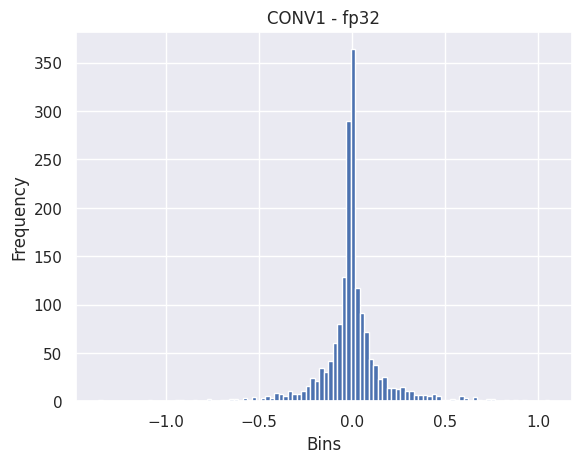

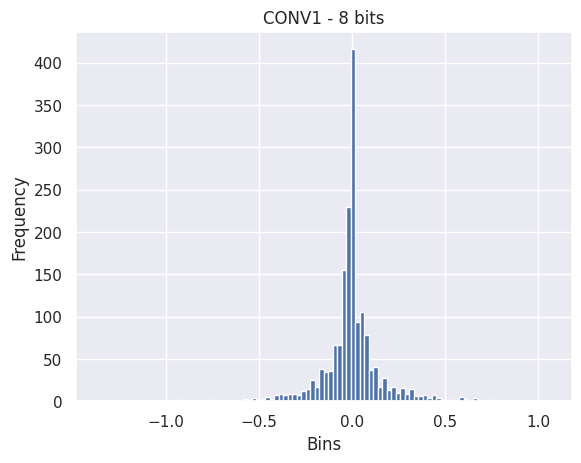

In [84]:
quantized_histogram = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(histogram_conv1)

# Evaluate the model's histogram
before = histogram_conv1(global_model)
plot_histogram(before[0], before[1],f"CONV1 - fp32")


after = quantized_histogram(global_model)
plot_histogram(after[0], after[1], f"CONV1 - {quantize_bits} bits")


In [85]:
print(before[1].shape, "\n",after[1].shape)

torch.Size([101]) 
 torch.Size([101])


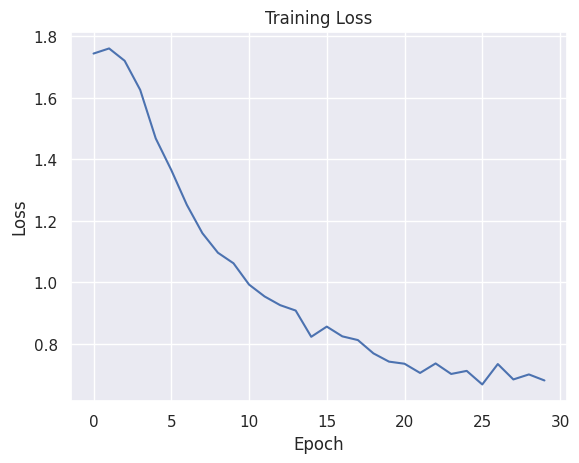

In [86]:
# plot the training loss
sns.set(style='darkgrid')
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [87]:
train_accs = [d.item() for d in train_accs]
test_accs = [d.item() for d in test_accs]

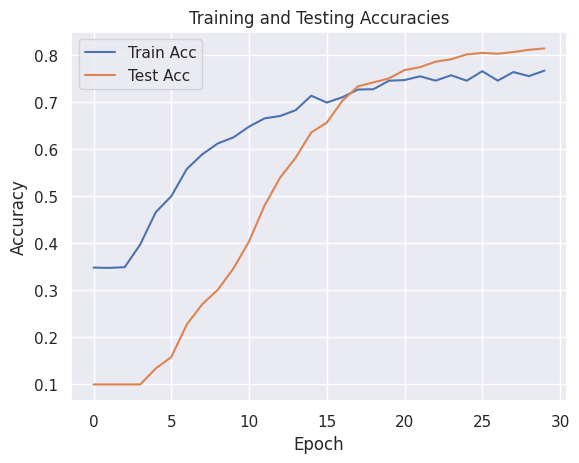

In [88]:
# plot the training and testing accuracies
sns.set(style='darkgrid')
plt.plot(train_accs, label='Train Acc')
plt.plot(test_accs, label='Test Acc')
plt.title('Training and Testing Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [89]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = server_test(global_model, test_loader, device,criterion=criterion)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 0.5348496609687805, Accuracy: 81.41999816894531%
44.77 MB
CPU Inference Latency: 11.49 ms / sample
CUDA Inference Latency: 2.94 ms / sample


In [90]:
cuda_device = torch.device("cuda:0")
cpu_device = torch.device("cpu:0")
# Test the model
loss, acc = evaluate_model(global_model, test_loader, device,criterion=criterion)
print(f'Loss: {loss}, Accuracy: {acc*100}%')
print_model_size(global_model)

# Measure inference latency
cpu_inference_latency = measure_inference_latency(model=global_model, device=cpu_device, input_size=(1,3,32,32), num_samples=100)
gpu_inference_latency = measure_inference_latency(model=global_model, device=cuda_device, input_size=(1,3,32,32), num_samples=100)
print("CPU Inference Latency: {:.2f} ms / sample".format(cpu_inference_latency * 1000))
print("CUDA Inference Latency: {:.2f} ms / sample".format(gpu_inference_latency * 1000))

Loss: 0.5350761115074157, Accuracy: 81.39999389648438%
44.77 MB
CPU Inference Latency: 6.55 ms / sample
CUDA Inference Latency: 2.93 ms / sample


In [91]:
save_model(global_model, "saved_models", f'resnet_fedlern_global_{time_stamp()}.pth')


In [92]:
save_quantized_model = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(save_model)
save_quantized_model(global_model, "saved_models", f'resnet_fedlern_{quantize_bits}bits_{time_stamp()}.pth')

In [93]:
def get_model_dict(model):
    return model.state_dict().copy()

dicta = get_model_dict(global_model)
dictd = to_quantized_model_decorator(global_optimizer, goptimizer_quant)(get_model_dict)(global_model)

In [1]:
for key in dicta:
    if 'weight' in key or 'bias' in key:
        print(key)
        hist = torch.histogram(dicta[key].to(torch.device('cpu')))
        plot_histogram(hist[0], hist[1], title=key+'Non-quantized')
        hist = torch.histogram(dictd[key].to(torch.device('cpu')))
        plot_histogram(hist[0], hist[1], title=key+'Quantized')
        if 'conv' in key:
            print(hist[0].shape)
            print(hist[1].shape)

 

NameError: name 'dicta' is not defined